In this notebook, I am going to try and create a high-performance model for pneumonia diagnosis based on X-Rays.

Let's get started by installing and importing the necessary libraries.

In [1]:
# Install the imutils library for image preprocessing
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=3ad933bb749c1d0de98bf4e9297a738d98f8aa19eb6be6da6cec77c25459454a
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Imorting necessary libraries
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as metrics

# Setting some variables for plotting via matplotlib
plt.rcParams["figure.figsize"] = (10, 10)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('lines', linewidth=3)
plt.rc('font', size=15)

In the code cell below, I'm fixing random seeds for reproducibility, although note that the apparent non-determinism of TensorFlow doesn't allow full reproducibility.

In [3]:
import random

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In the following couple of cells, we will be reading image jpeg files from the disk. The images are separated into directories based on their diagnosis (NORMAL and PNEUMONIA) and purpose (test, train, val). Thanks to the separation via diagnosis, I can easily create corresponding labels for each category.

Note that the PNEUMONIA X-Rays in this dataset are also divided into bacterial and viral pneumonia (which can be seen from their filenames). However, in this particular notebook, I will only be reviewing binary classification - NORMAL vs PNEUMONIA.

I will not be loading the images into memory right now - instead, this will be done by ImageDataGenerator objects during training. This is because I wanted to feed 512 x 512 x 1 images, which was too big for loading the entire dataset into memory. So right now, I am only declaring lists containing image paths, not image arrays.

The labels are strings as well since this is what's required by the *flow_from_dataframe* method of the *ImageDataGenerator* class that I will be using later.

In [4]:
# Find and load normal image directories into a list
directory_test = '../input/chest-xray-pneumonia//chest_xray/chest_xray/test/NORMAL/'
directory_train = '../input/chest-xray-pneumonia//chest_xray/chest_xray/train/NORMAL/'
directory_val = '../input/chest-xray-pneumonia//chest_xray/chest_xray/val/NORMAL/'
image_paths_norm = sorted(list(paths.list_images(directory_test))) + \
                   sorted(list(paths.list_images(directory_train))) + \
                   sorted(list(paths.list_images(directory_val)))

# Declare a normal label list
labels_norm = ['Normal'] * len(image_paths_norm)

In [5]:
# Find and load pneumonia image directories into a list
directory_test_pn = '../input/chest-xray-pneumonia//chest_xray/chest_xray/test/PNEUMONIA/'
directory_train_pn = '../input/chest-xray-pneumonia//chest_xray/chest_xray/train/PNEUMONIA/'
directory_val_pn = '../input/chest-xray-pneumonia//chest_xray/chest_xray/val/PNEUMONIA/'
image_paths_pn = sorted(list(paths.list_images(directory_test_pn))) + \
                 sorted(list(paths.list_images(directory_train_pn))) + \
                 sorted(list(paths.list_images(directory_val_pn)))

# Declare a pneumonia label list for binary
labels_pn = ['Pneumonia'] * len(image_paths_pn)

# Merge the image and label lists together and turn them into NumPy arrays
image_paths = np.array(image_paths_norm + image_paths_pn)
labels = np.concatenate((labels_norm, labels_pn))

It's interesting to see how the diagnoses are distributed in the dataset. Below is a bar plot where we can see that pneumonia samples are predominant in the dataset - about 73%. Thanks to this, the model should be able to easily learn to identify pneumonia and thus should not need any class weight adjustment.

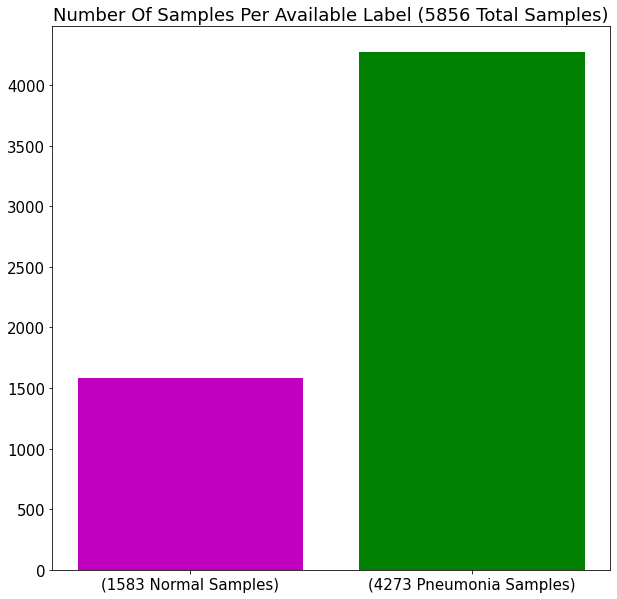

In [6]:
# Plot a bar with numbers of normal and pneumonia diagnoses
plt.bar([1, 2], height=[len(labels_norm), len(labels_pn)], 
        tick_label=['({0:d} Normal Samples)'.format(len(labels_norm)), 
                    '({0:d} Pneumonia Samples)'.format(len(labels_pn))], 
        color=['m', 'g'])

plt.title('Number Of Samples Per Available Label ({0:d} Total Samples)'.
          format(len(labels_norm) + len(labels_pn)))

plt.show()

Now, let's plot a couple of images from each diagnosis to see how they look like.

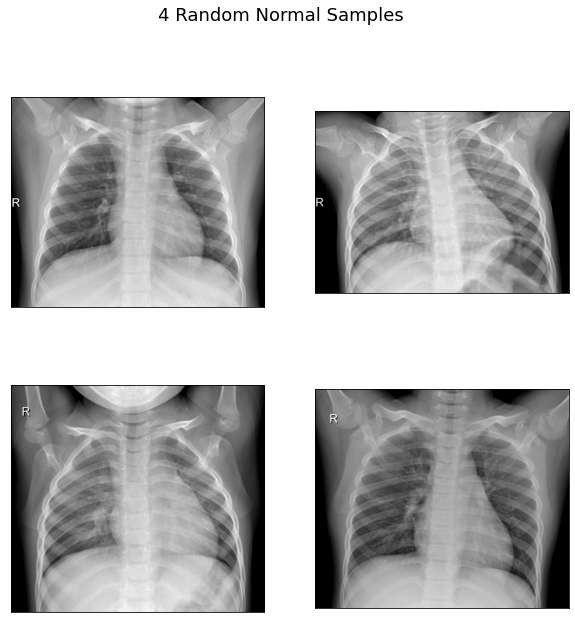

In [7]:
# Build a 2 x 2 figure
rows, columns = 2, 2
fig, axes = plt.subplots(rows, columns)

# Choose random indices for image selection
norm_indices = np.random.choice(len(image_paths_norm), rows * columns)
pn_indices = np.random.choice(len(image_paths_pn), rows * columns)

# Make a list with images to plot
imgs_to_plot_norm = [image_paths_norm[i] for i in norm_indices]
imgs_to_plot_pn = [image_paths_pn[i] for i in pn_indices]

# Variable used for indending through the image list
current_index = 0

# Set figure title
fig.suptitle('4 Random Normal Samples')

# Plot normal images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_norm[current_index])        
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        current_index +=1
        
plt.show()

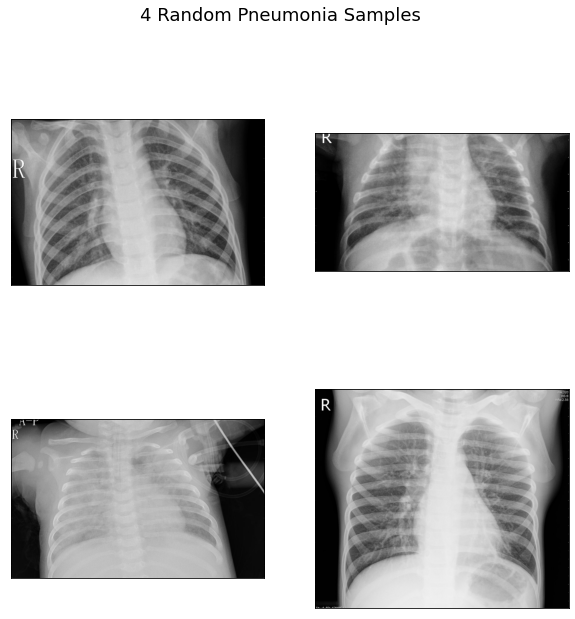

In [8]:
fig, axes = plt.subplots(rows, columns)

current_index = 0

# Set figure title
fig.suptitle('4 Random Pneumonia Samples')

# Plot pneumonia images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_pn[current_index])        
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        current_index +=1
        
plt.show()

Generally, pneumonia manifests itself in alveoli consolidations mainly caused by bacteria and fluid. The differences between healthy and pneumonia X-Rays are pretty clearly visible, though in some images, the differences may not be as definite. 

As our next step, we will divive our image paths and labels into training, validation, and test sets. The purpose of these sets is as follows:
1. **Training data** will be used to update the weights of the network to achieve high performance.
2. **Validation data** will be used to tweak model hyperparameters to achieve low loss, high accuracy, and no overfitting.
3. **Test data** will be used for final performance validation and to make sure that the model doesn't overfit to the parameters we choose based on validation performance.

Note that I am not using the splits proposed by the original publisher of the data - this is because I have been unable to achieve high performance with it. Maybe it's possible, but I decided not to waste time and split the data anew myself.

For splitting, I am using scikit-learn's train_test_split method. Since this method only divides the dataset into training and test sets, I've then further divided the test set into validation and test sets - the former and latter halves of the initial test set respectively. The data distribution is 70% training and 15% validation & test data.

In [9]:
from sklearn.model_selection import train_test_split

# Divide the image path & label arrays into train & test sets. This is done without loading images to save memory
X_train_dir, X_test_dir, y_train, y_test = \
                                           train_test_split(image_paths, labels, test_size=0.3)

# Divide the test set into validation (for use during training) and test (for post-training evaulation) sets
X_val_dir, y_val = X_test_dir[:len(X_test_dir) // 2], \
                   y_test[:len(y_test) // 2]

X_test_dir, y_test = X_test_dir[len(X_test_dir) // 2:], \
                     y_test[len(y_test) // 2:]

I will be feeding the data into the model via an *ImageDataGenerator* object. However, because we have image paths rather than image arrays, we can't use the *flow* method. Instead, we have to use the *flow_from_dataframe* method, which requires DataFrames containing image paths under the "filename" column and labels under the "class" column.

Below, we create DataFrames for each of our sets.

In [10]:
# Create DataFrames for the image generator
train_df = pd.DataFrame(np.transpose([X_train_dir, y_train]), 
                        columns=['filename', 'class'])

val_df = pd.DataFrame(np.transpose([X_val_dir, y_val]), 
                      columns=['filename', 'class'])

test_df = pd.DataFrame(np.transpose([X_test_dir, y_test]), 
                       columns=['filename', 'class'])

Next, we declare ImageDataGenerator objects for batch input along with data augmentation to reduce overfitting. Data augmentation is only done on the training data (via the *datagen* object) - as for the validation and test data, only scaling to [0, 1] was performed (via the *test_datagen* object).

For data augmentation, I picked parameters so that the output images would be realistic and similar to what the model would be seeing in real-world use.

After declaring generator objects, I declare *DataFrameIterator* objects via the *flow_from_dataframe* method. I passed arguments for: 
1. Target image size (512 x 512). 
2. Color mode (grayscale).
3. Batch size (64).
4. Class mode (binary).
5. Shuffling (*True* for training data and *False* for validation & test data).

When called, the *DataFrameIterator* will read images from the provided filenames, resize them, convert string labels to binary ("Pneumonia" to 1 and "Normal" to 0), and return 64 image-label pairs.

In [11]:
# Set the batch size for the generator and training
BATCH_SIZE = 64

# Declare an image generator for image augmentation
datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             horizontal_flip=True,
                             brightness_range=[0.5,1.0],
                             rotation_range=5)


# Declare an image generator for validation & testing without generation
test_datagen = ImageDataGenerator(rescale = 1./255)

# Declare generators for training, validation, and testing from DataFrames
train_gen = datagen.flow_from_dataframe(train_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen = test_datagen.flow_from_dataframe(val_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.


For a little added input pipeline efficiency, I've also created *tf.Dataset* objects. I wanted to make use of the *prefetch* method of the *tf.Dataset* class to accelerate training a little. 

Image reading from the disk is a huge bottleneck for the model, and although my approach isn't the best one, it accelerates each epoch by about 20-30 seconds.

In [12]:
# Declare TensorFlow Datasets for more efficient training
train_data = tf.data.Dataset.from_generator(lambda: train_gen,
                                            output_types=(tf.float32, tf.int32),
                                            output_shapes=([None, 512, 512, 1], [None, ]))

val_data = tf.data.Dataset.from_generator(lambda: val_gen,
                                          output_types=(tf.float32, tf.int32),
                                          output_shapes=([None, 512, 512, 1], [None, ]))

test_data = tf.data.Dataset.from_generator(lambda: test_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 512, 512, 1], [None, ]))

Now, let's see how our training generator works in terms of data augmentation. Let's load a couple of images from the disk, pass them to the *flow* method of the generator (this method acccepts image arrays), and plot the base and augmented images in RGB.

As you'll see, the augmented images look pretty decently and are realistic enough for training.

In [13]:
images_to_augment = []

for image_path in image_paths[:4]:
    image = load_img(image_path, target_size=(512, 512))
    image = img_to_array(image)
    images_to_augment.append(image)
    
images_to_augment = np.array(images_to_augment)

images_augmented = next(datagen.flow(x=images_to_augment,
                                batch_size=10,
                                shuffle=False))

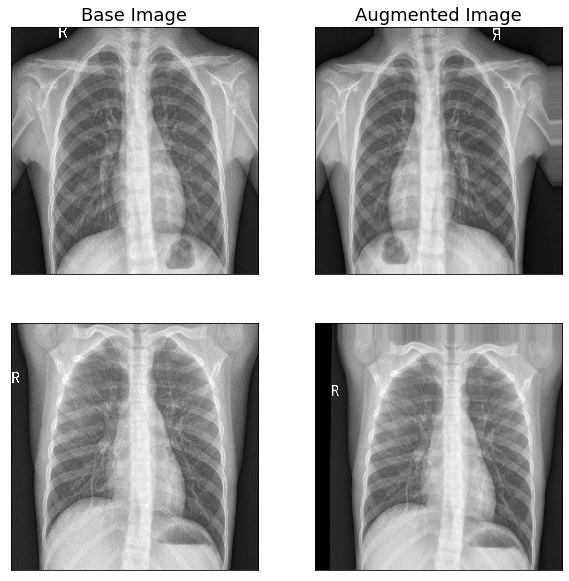

In [14]:
from tensorflow.keras.preprocessing.image import array_to_img

fig, axes = plt.subplots(2, 2)

for i in range(2):
    axes[i, 0].imshow(array_to_img(images_to_augment[i]), 
                      interpolation='nearest')
    
    axes[i, 1].imshow(array_to_img(images_augmented[i]), 
                      interpolation='nearest')
    
    axes[i, 0].set_xticks([])
    axes[i, 1].set_xticks([])
    
    axes[i, 0].set_yticks([])
    axes[i, 1].set_yticks([])
    
columns = ['Base Image', 'Augmented Image']
for ax, column in zip(axes[0], columns):
    ax.set_title(column) 
    
plt.show()

And below is how I used the *prefetch* method of the *tf.Dataset* class that I talked about.

In [15]:
def feed_data(dataset):
    """Feed data to a model with prefetching
    
    Arguments:
        dataset (tf.Dataset): A dataset that to be fed to the model
        
    Returns:
        dataset (tf.Dataset): A prefetched dataset
    """
    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  
    
    return dataset

Finally, we've reached model creation. The model architecture that you see below is the final architecture that I chose after some testing. I've saved the results of my test runs in csv files, and we'll be plotting them later so that you see how my model selection went.

Now, let's define the model and then plot its summary along with the model architecture.

In [16]:
# Define the CNN Keras model
def create_model():
    """
    Create a model
    
    Returns:
        model (tf.keras.Model): An instance of Model
    """
    
    # Model input
    input_layer = layers.Input(shape=(512, 512, 1), name='input')    

    # First block
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_1')(input_layer)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
    x = layers.Dropout(0.1, name='dropout_1')(x)
    
    # Second block
    x = layers.Conv2D(filters=96, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_2')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
    x = layers.Dropout(0.1, name='dropout_2')(x)

    # Third block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_3')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
    x = layers.Dropout(0.1, name='dropout_3')(x)
    
    # Fourth block
    x = layers.Conv2D(filters=160, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_4')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
    x = layers.Dropout(0.1, name='dropout_4')(x)

    # Fifth block
    x = layers.Conv2D(filters=192, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_5')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
    x = layers.Dropout(0.1, name='dropout_5')(x)
    
    # Sixth block
    x = layers.Conv2D(filters=224, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_6')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)
    x = layers.Dropout(0.1, name='dropout_6')(x)
    
    # Seventh block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_7')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
    x = layers.Dropout(0.1, name='dropout_7')(x)

    # Pooling and output
    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)    
    output = layers.Dense(units=1, 
                          activation='sigmoid', 
                          name='output')(x)

    # Model creation and compilation
    
    model = Model (input_layer, output)    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

In [17]:
# Create a Model object
model = create_model()

In [18]:
# See the layer and parameter summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      640       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 96)      55392     
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 128, 128, 96)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 96)      0     

In [19]:
from tensorflow.keras.utils import plot_model

# See graphical representation of the model
plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Another method that I've used to optimize model performance was learning rate decay. I've used exponential decay since it seemed the most promising - however, other decay schedules may show better performance.

The *lr_decay* method is to be given to Keras' *LearningRateScheduler* object and then provided to the model as a callback. 

In [20]:
# Set up exponential learning rate decay
def lr_decay(epoch):
    """
    Create a learning rate reduction scheduler
    
    Arguments:
        epoch (int): The index of the current epoch        
        
    Returns:
        lr (float): Learning rate as of epoch
    """
    
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

Below, I create three callbacks for training - the aforementioned *LearningRateScheduler*, a *CSVLogger* object for model result saving, and a *ModelCheckpoint* object for model weight saving after each epoch. I did the last two to save results and models since I did my analysis in multiple notebook runs.

Here, I am declaring the *CSVLogger* and *ModelCheckpoint* for demonstration - we won't be using them since I've already done the training & testing.

In [21]:
# Import classes for metric saving, model saving, and LR reduction
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
csv_logger = CSVLogger(filename='7-layer_double_adam_512_aug_bn_dropout01_explr.csv')
model_checkpoint = ModelCheckpoint(filepath='7-layer_double_adam_512_aug_bn_dropout01_explr_{epoch:04d}.hdf5')

Next, we need to define the number of training and validation steps. I've calculated them by diving sample number by batch size and then rounding the result down. Since the result is rounded down, not all images will be fed into the model. I did this consciously since I've also tested models without data augmentation - without data augmentation, I might have been providing duplicate images to the model, which I wanted to avoid.

In [22]:
# Calculate the number of steps for training and validation
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

Below, I commence training will validation data and callbacks. I've commented this part out because training takes a long time and because I have the results anyway.

In [23]:
history = model.fit(feed_data(train_data),                    
                    epochs=50,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=(feed_data(val_data)),
                    validation_steps=val_steps,                    
                    shuffle=False,
                    callbacks=[lr_scheduler, csv_logger, model_checkpoint])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
64/64 [==============================] - 183s 3s/step - loss: 0.6367 - accuracy: 0.7262 - val_loss: 0.5969 - val_accuracy: 0.7296
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009048374180359595.
64/64 [==============================] - 141s 2s/step - loss: 0.4862 - accuracy: 0.7282 - val_loss: 0.4398 - val_accuracy: 0.7296
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0008187307530779819.
64/64 [==============================] - 138s 2s/step - loss: 0.4264 - accuracy: 0.7546 - val_loss: 0.2957 - val_accuracy: 0.8666
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0007408182206817179.
64/64 [==============================] - 135s 2s/step - loss: 0.3566 - accuracy: 0.8370 - val_loss: 0.2555 - val_accuracy: 0.8906
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0006703200460356394.
64/64 [=========

Now, we load the weights of the model that I think did the best among my tested architectures. It's probably not the very best possible model, but I didn't dive too deep into model tweaking. However, I did reduce overfitting.

In [24]:
# Load the weights of a pretrained model
model.save_weights("model_weights.hdf5")
# model.load_weights('/kaggle/input/model-final/7-layer_adam_512_aug_dropout01_explr_0023.hdf5')

In [25]:
# Evaluate the model on the test set
test_steps = test_gen.samples // BATCH_SIZE
model.evaluate(test_data, steps=test_steps)

# Declare an image generator on test data for augmented images
test_aug_gen = datagen.flow_from_dataframe(test_df,
                                           target_size=(512, 512),
                                           color_mode='grayscale',
                                           batch_size=BATCH_SIZE,
                                           class_mode='binary',
                                           shuffle=False)

test_aug_data = tf.data.Dataset.from_generator(lambda: test_aug_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 512, 512, 1], [None, ]))

# Evaluate the model on augmented test data
test_aug_steps = test_aug_gen.samples // BATCH_SIZE
model.evaluate(test_aug_data, steps=test_aug_steps)

13/13 [==============================] - 19s 1s/step - loss: 0.1382 - accuracy: 0.9555
Found 879 validated image filenames belonging to 2 classes.
13/13 [==============================] - 26s 2s/step - loss: 0.1361 - accuracy: 0.9447


[0.13605855405330658, 0.9447115659713745]

In [26]:
# Calculate precision and recall based on  test data

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

predictions = model.predict(test_data, steps=test_steps).flatten()
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, predictions)
recall.update_state(y_true, predictions)

In [27]:
print('Precision with base test data:', precision.result().numpy())
print('Recall with base test data:', recall.result().numpy())

Precision with base test data: 0.70994943
Recall with base test data: 0.71965814


In [28]:
# Calculate precision and recall based on augmented test data

precision.reset_states()
recall.reset_states()

predictions_aug = model.predict(test_aug_data, steps=test_steps).flatten()
y_true = test_gen.classes[:len(predictions_aug)]

precision.update_state(y_true, predictions_aug)
recall.update_state(y_true, predictions_aug)

In [29]:
print('Precision with augmented test data:', precision.result().numpy())
print('Recall with augmented test data:', recall.result().numpy())

Precision with augmented test data: 0.70896786
Recall with augmented test data: 0.71623933


And a confusion matrix for a better look at true and false prediction counts.

In [30]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, predictions > 0.5)

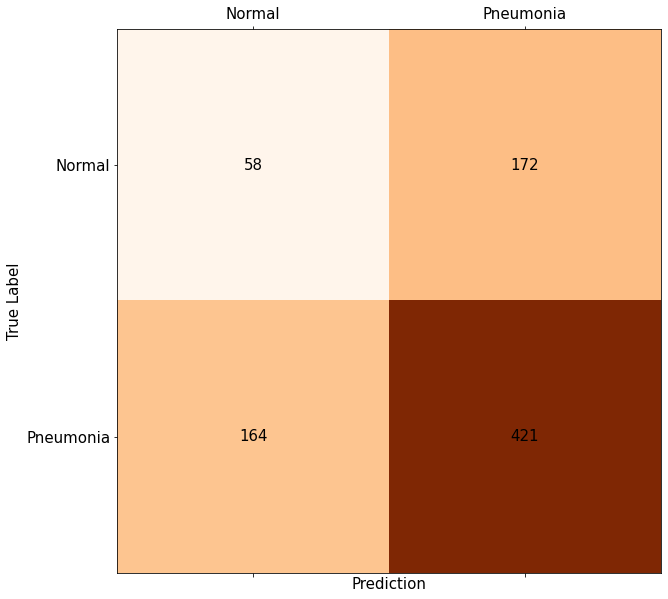

In [31]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat, cmap=plt.cm.Oranges)

ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')
        
plt.show()

To give you an idea of how the model performs, let's also plot a few images along with their predictions and true labels.

In [32]:
from tensorflow.keras.preprocessing.image import array_to_img

def plot_image(image, prediction, label):
    """
    Plot images along with predictions and true labels
    
    Arguments:
        image (4-D array): The image to visualize
        prediction (2-D array): Model's prediction on the image
        label (1-D array): True label of the image
    """
    
    label_names = ['Normal', 'Pneumonia']    
        
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(array_to_img(image * 255), interpolation='nearest', cmap='gray')
    
    if prediction <= 0.5:
        predicted_label = 0
    else:
        predicted_label = 1

    if predicted_label == label:
        color = 'blue'
    else:
        color = 'red' 
    
    plt.xlabel("{} {:2.0f}% \n ({})".format(label_names[predicted_label], 100 * prediction[0], label_names[label]), color=color)

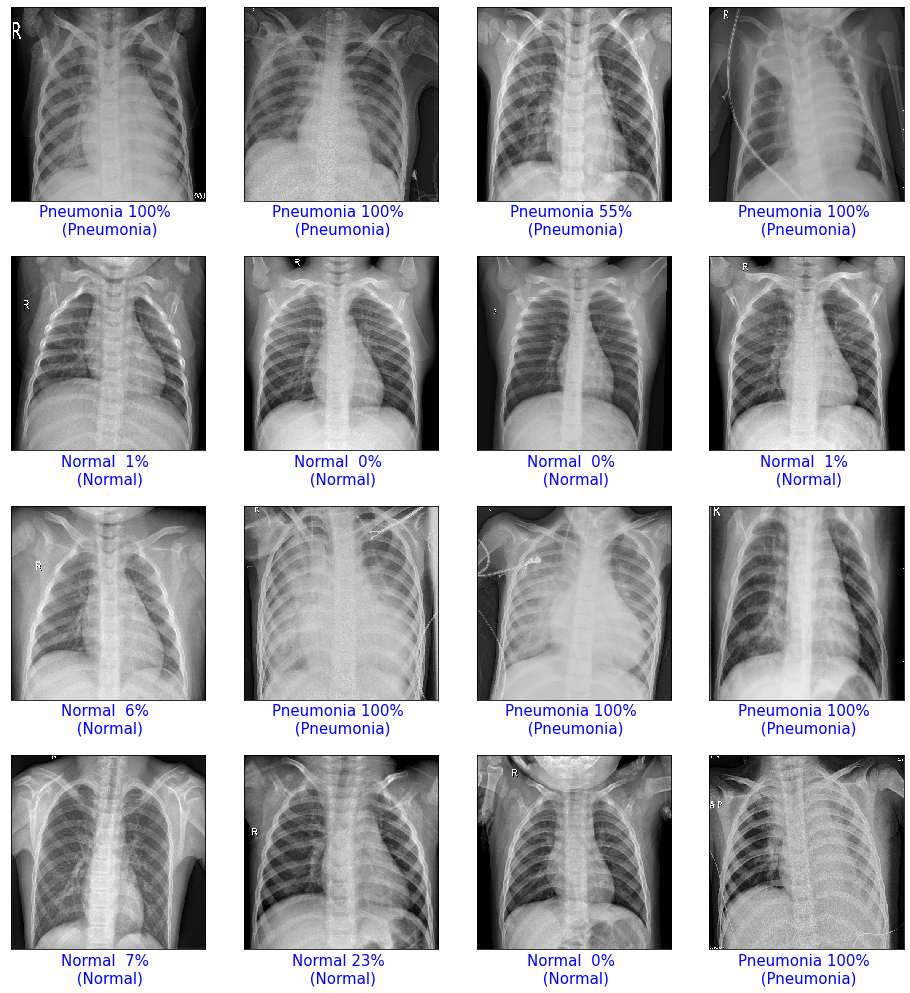

In [33]:
images, labels = next(iter(test_data))
y_pred = model.predict(images)
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(images[i], y_pred[i], labels[i])
plt.show()

Above, I've used 0.5 as the decision threshold. This threshold is also used during training for accuracy computations.

You can adjust the decision threshold in the [0, 1] range to tweak the confidence with which the model will make predictions. Needless to say, this will change how well the model performs. For a better look, let's see how the metrics change with a few thresholds values.

In [34]:
def calculate_metrics(predictions, labels, threshold):
    """
    Calculate precision, recall, and binary accuracy given a dataset
    
    Arguments:
        predictions (1-D array): Model predictions
        labels (1-D array): True labels
        threshold (float): The metrics' decision threshold
        
    Returns:
        Mean of metrics on all batches of data
    """
    
    precision = tf.keras.metrics.Precision(thresholds=threshold)
    recall = tf.keras.metrics.Recall(thresholds=threshold)
    binary_accuracy = tf.keras.metrics.BinaryAccuracy(threshold=threshold)        
    
    precision.update_state(y_true, predictions) 
    recall.update_state(y_true, predictions)     
    binary_accuracy.update_state(y_true, predictions) 
        
    return precision.result().numpy(), recall.result().numpy(), binary_accuracy.result().numpy()

In [35]:
thresholds = np.linspace(0, 1, 100)

precisions, recalls, binary_accuracies = [], [], []

In [36]:
for threshold in thresholds:
    precision, recall, binary_accuracy = calculate_metrics(predictions, y_true, threshold)
    
    precisions.append(precision)
    recalls.append(recall)
    binary_accuracies.append(binary_accuracy)

In [37]:
def plot_metrics(precisions, recalls, accuracies, thresholds):
    """
    Plot the dependency of metrics on threshold values
    
    Arguments:
        precisions (1-D array): Precisions calculated on thresholds
        recalls (1-D array): Recalls calculated on thresholds
        accuraries (1-D array): Accuracies calculated on thresholds
        thresholds (1-D array): Thresholds upon which metrics were evaluated
    
    """
    
    plt.plot(thresholds, precisions, label='Precison')
    plt.plot(thresholds, recalls, '--', label='Recall')
    plt.plot(thresholds, accuracies,'-.', label='Accuracy')
    
    plt.xticks(np.linspace(0, 1, 10))
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.ylim([0.7, 1])
    plt.grid()
    plt.legend()
    plt.title('The Dependence Of Metric Scores On The Decision Threshold')
    plt.show()

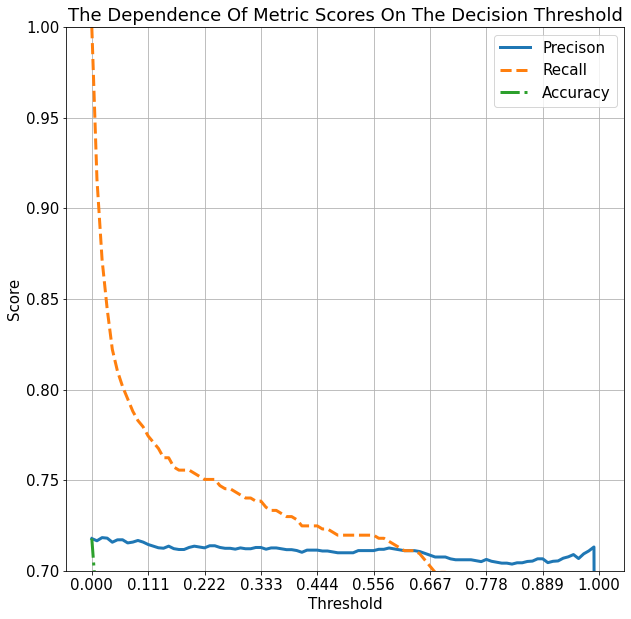

In [38]:
plot_metrics(precisions, recalls, binary_accuracies, thresholds)

As we can see, precision is low with low thresholds and high with high thresholds. The dependence for recall is inverse - it's the highest when the threshold is 0 and the lowest when it's 1. As for accuracy, it's somewhat dependent on precision and recall, so its highest scores are somewhere in the middle.

And finally, let's have a look at saliency maps and Grad-CAMs.

In [39]:
pip install https://github.com/raghakot/keras-vis/archive/master.zip

     / 45.5 MB 49.4 MB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30857 sha256=5057fa7e697301e9da58b8c6c0561de879882e011d735afbd0af9c62c57fd538
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ip87mjk/wheels/86/18/04/ffe2ca1aa9fedc1e1b11a85372ad6c5ba2b4f25592d704737b
Successfully built keras-vis
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [40]:
from vis.visualization import visualize_cam, visualize_saliency, visualize_activation, overlay
from vis.utils import utils

images, labels = next(iter(test_data))

predictions = model.predict(images)

ImportError: cannot import name '_Conv' from 'keras.layers.convolutional' (/opt/conda/lib/python3.7/site-packages/keras/layers/convolutional.py)

In [41]:
def visualize_cams(images, predictions, labels): 
    '''
    Plot Grad-CAMs on a batch of images
    
    Arguments:
        images (4-D array): Images to compute Grad-CAM on
        predictions (2-D array): Predicted labels
        labels (1-D array): True labels
    '''
    
    rows, cols = 3, 3

    fig, axes = plt.subplots(rows, cols)
    fig.set_size_inches(2*2*cols, 2.2*2*rows)    
    fig.suptitle('Grad-CAMs On 9 Images')
    current_index = 0
    label_names = ['Normal', 'Pneumonia']
    
    for i in range(rows) :
        for j in range(cols):
            image = images[current_index]
            image_rgb = tf.image.grayscale_to_rgb(image)
            visualization = visualize_cam(model, -1, filter_indices=0, seed_input=image, penultimate_layer_idx=-4)            
            
            axes[i, j].imshow(tf.image.grayscale_to_rgb(image))
            axes[i, j].imshow(visualization, interpolation='nearest', alpha=0.6)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            
            if predictions[current_index] <= 0.5:
                predicted_label = 0
            else:
                predicted_label = 1                 
            
            if predicted_label == labels[current_index]:
                color = 'blue'
            else:
                color = 'red'
            
            label = labels[current_index]
            axes[i, j].set_xlabel("{} {:2.0f}% \n ({})".format(label_names[predicted_label], 100 * predictions[current_index][0], label_names[label]), color=color)
            current_index += 1
            
    plt.show()

NameError: name 'visualize_cam' is not defined

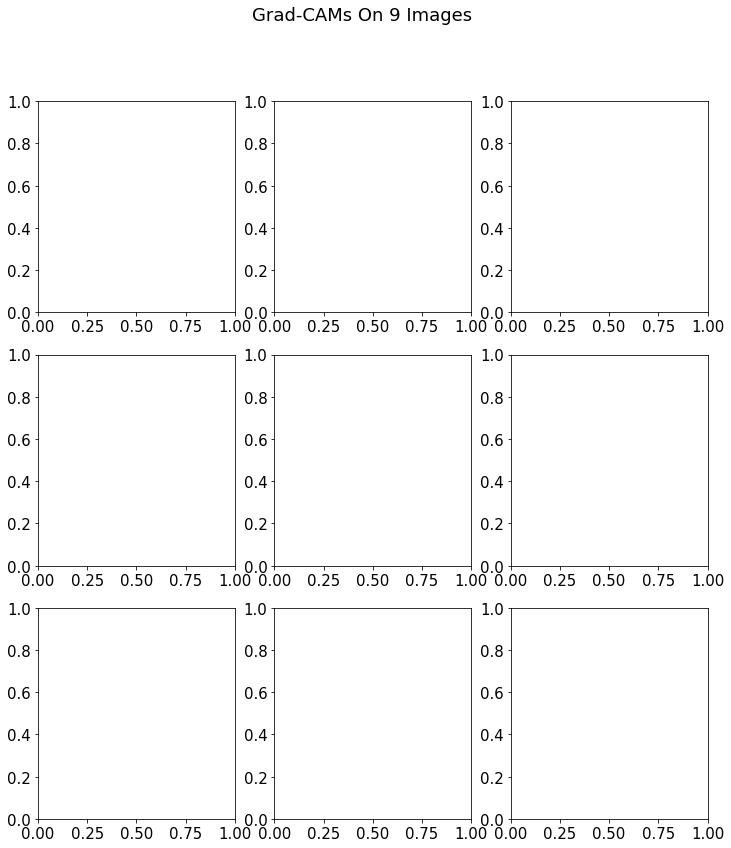

In [42]:
# Visualize Grad-CAMs
visualize_cams(images, predictions, labels)

In [43]:
def visualize_sal(images, predictions, labels):
    """
    Plot saliency map on a batch of images
    
    Arguments:
        images (array-like): Images to compute saliency upon
        predictions (array-like): Model's predictions on images
        labels (array-like): True labels of the images
    """
    
    rows, cols = 3, 3

    fig, axes = plt.subplots(rows, cols)
    fig.set_size_inches(2*2*cols, 2.2*2*rows)
    fig.suptitle('Saliency Maps On 9 Images')
    current_index = 0
    label_names = ['Normal', 'Pneumonia']    
    
    for i in range(rows) :
        for j in range(cols):
            image = images[current_index]
            image_rgb = tf.image.grayscale_to_rgb(image)
            visualization = visualize_saliency(model, -1, filter_indices=None, seed_input=image)                  
            
            #axes[i, j].imshow(tf.image.grayscale_to_rgb(image))
            axes[i, j].imshow(visualization * 255, interpolation='nearest', alpha=1)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            
            if predictions[current_index] <= 0.5:
                predicted_label = 0
            else:
                predicted_label = 1                 
            
            if predicted_label == labels[current_index]:
                color = 'blue'
            else:
                color = 'red'
            
            label = labels[current_index]
            axes[i, j].set_xlabel("{} {:2.0f}% \n ({})".format(label_names[predicted_label], 100 * predictions[current_index][0], label_names[label]), color=color)
            current_index += 1

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

NameError: name 'visualize_saliency' is not defined

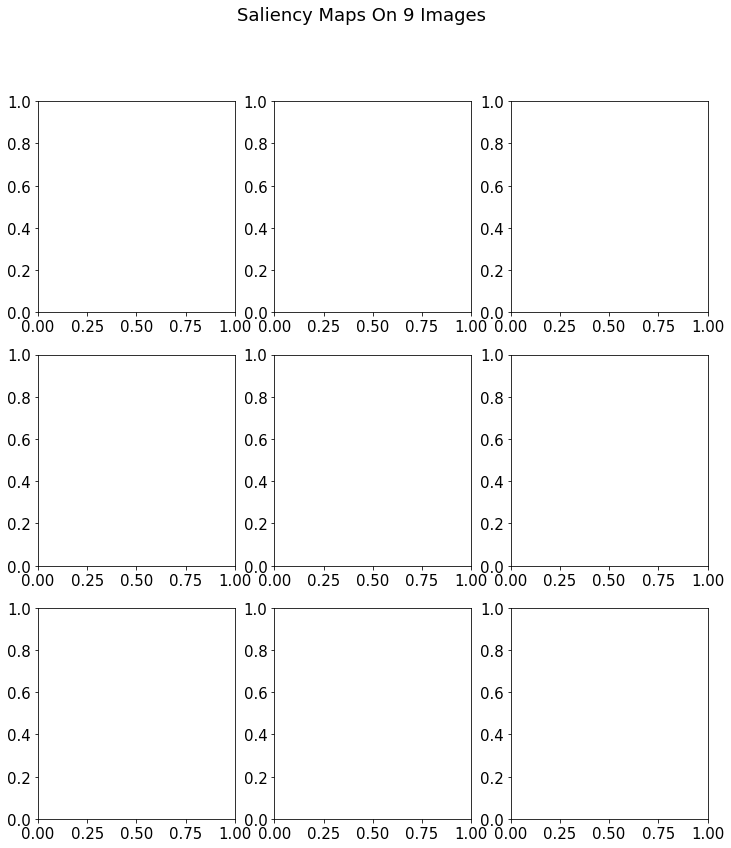

In [44]:
# Visualize saliency maps
visualize_sal(images, predictions, labels)

Based on saliency maps and Grad-CAMs, the model seems to pay attention to the right areas on the images (i.e. the lungs). However, the 1st and 9th Grad-CAMs don't look too good - the upper left corner is excessively highlighted in them. This may be because the model needs additional tweaking, or maybe Grad-CAM failed to localize regions of interest with those particular images. On saliency maps, these images look fine (although the saliency maps are very vague as well).

For real-world deployment, models like this would require more in-depth analysis and tweaking. Furthemore, cooperation between ML engineers and doctors would be necessary to identify weak points & faulty predictions and then try to fix the model. 

With all that said, this experiment has been pretty interesting, and hopefully, you've learned a thing or two from it (particularly regarding the *ImageDataGenerator* class and overfitting reduction - I certainly did).